# Guided dFBA with uptake constraints from NMR

@author: Aidan Pavao for Massachusetts Host-Microbiome Center
 - Compute dynamic flux balance analysis (dFBA) solutions
 - Use python 3.8+ for best results
 - See README.md for dependencies
 
Copyright 2021 Massachusetts Host-Microbiome Center

   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at

   [http://www.apache.org/licenses/LICENSE-2.0](http://www.apache.org/licenses/LICENSE-2.0)

   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.

## Import packages

In [1]:
import csv
import math

import cobra as cb
from cobra.flux_analysis import flux_variability_analysis as fva
from cobra.flux_analysis.loopless import loopless_solution as lsol
from cobra.flux_analysis import pfba
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors
import openpyxl as xl

## Conversion factors

Conversion factors to transform signal to concentration.

These were determined by as described in the Methods section of our C.diff HRMAS pre-print. _These are estimates of concentration and should not be taken as precise values._

In [2]:
# Scale Factors - calculated from HMDB reference spectra

scale_f = {
    'glc' : 1.,
    'ac'  : 1.,
    'alaL': 1.,
    'eto' : 1.,
    'lacS': 1.,
    'but' : 1.,
    'buta': 1.,
    'proL': 1.,
    '5apn': 1.,
    'leuL': 1.,
    'ival': 1.,
    'isocap': 1.,
}

## Some key functions

Helper functions:
1. Evaluate logistic function at timepoint.
1. Evaluate derivative of logistic function at timepoint.
1. Update the uptake/secretion reaction bounds with the logistic derivative. This function evaluates both the logistic curve and its derivative at the timepoint, updates the bounds, and returns both solutions. Pass in the logistic coefficients calculated with MATLAB.


In [3]:
def logistic (L, k, x0, C, x):
    """Evaluate the logistic function at point x."""
    return L/(1. + math.exp(-1*k*(x - x0))) + C

def ddx_logistic(L, k, x0, x):
    """Evaluate the derivative of the logistic function at point x."""
    return k*L*math.exp(-k*(x - x0))/(1. + math.exp(-1*k*(x - x0)))**2

def find_minmax_bounds(met, Ls, ks, x0s, Cs, t):
    all_bounds = []
    all_signal = []
    for L in Ls:
        for k in ks:
            for x0 in x0s:
                all_bounds.append(ddx_logistic(scale_f[met]*L, k, x0, t))
                for C in Cs:
                    all_signal.append(logistic(scale_f[met]*L, k, x0, scale_f[met]*C, t))
    return min(all_bounds), max(all_bounds), min(all_signal), max(all_signal)

def update_uptake_bounds(model, t, met, Ls, ks, x0s, Cs):
    """Update the uptake rate of exchange reaction at timepoint t."""
    logistic_sol = logistic(scale_f[met]*Ls[0], ks[0], x0s[0], scale_f[met]*Cs[0], t)
    uptake_rate = ddx_logistic(scale_f[met]*Ls[0], ks[0], x0s[0], t)
    uptake_lb, uptake_ub, signal_lb, signal_ub = find_minmax_bounds(met, Ls[1:], ks[1:], x0s[1:], Cs[1:], t)
    if met in ['glc', 'proL', 'leuL']:
        rid = 'Ex_' + met
        uptake_rate *= -1
        uptake_lb *= -1
        uptake_ub *= -1
        if met != 'leuL':
            model.reactions.get_by_id(rid).upper_bound = uptake_ub
    elif met in ['ival', 'isocap', '5av']:
        rid = 'Sec_' + met
        model.reactions.get_by_id(rid).upper_bound = uptake_ub
    else:
        rid = 'Sec_' + met
    if met == 'leuL':
        model.reactions.get_by_id(rid).lower_bound = 0
        model.reactions.get_by_id(rid).upper_bound = 1000
    else:
        model.reactions.get_by_id(rid).lower_bound = uptake_lb
    return logistic_sol, uptake_rate, uptake_lb, uptake_ub, signal_lb, signal_ub


## Plot function

In [4]:
def areaplot(df, dl, du, t_max=36, y_max=1.5, ylabel='flux (mol/gDW/h)'):
    f = plt.figure(figsize=(14, 10), )#fontsize=30,
    ax = plt.axes(
        xticks=(range(0, t_max+1, 12)),
        xlim=(0, t_max),
        ylim=(0, y_max),
    )
    for met, ser in df.iteritems():
        ser.index.name = 'index'
        p = ax.plot(ser.index.to_numpy(), ser.to_numpy(), '-', label=met, lw=5)
        color = matplotlib.colors.to_rgb(p[0].get_color())
        color = color + (0.2,)
        ax.fill_between(dl.index.to_numpy(), dl[met].to_numpy(), du[met].to_numpy(), color=color, label='_nolegend_')
    ax.set_xlabel('time (h)', fontsize=30, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=30, fontweight='bold')
    plt.xticks(ax.get_xticks(), weight='bold')
    plt.yticks(ax.get_yticks(), weight='bold')
    plt.legend()
    
def niceplot(df, t_max=48, ylabel='flux (mol/gDW/h)'):
    ax = df.plot(
        figsize=(14, 10),
        xticks=(range(0, t_max+1, 12)),
        xlim=(0, t_max),
        ylim=(0, None),
        fontsize=30,
        lw=5,
    )
    ax.set_xlabel('time (h)', fontsize=30, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=30, fontweight='bold')
    plt.xticks(ax.get_xticks(), weight='bold')
    plt.yticks(ax.get_yticks(), weight='bold')

## Main dFBA program

In [75]:
def dfba_main(specsheet, traced, modelfile='../../data/icdf843.json', t_max=48, resolution=1, obj='ATP_sink', ko=None):
    """Main dFBA function. Computes successive FBA solutions and plots the concentration, uptake rates, and tracked reaction fluxes.
       
       Arguments:
       specsheet -- path to tsv sheet containing logistic parameters
       traced -- list of reaction ids to be traced over the timecourse
       
       Keyword arguments:
       modelfile -- location of metabolic model
       t_max -- end timepoint in hours (default 48)
       resolution -- number of hours per dFBA sample (default 1)
       """
    
    sample_times = [0, 12, 20, 28, 36]
    
    print(f"""dFBA log: Begin dFBA analysis with sheet
          {specsheet.split('/')[-1]}, endpoint
          {t_max} hours, and resolution {resolution}.""")
    
    # Load metabolic model and logistic fit specs #
    print('dFBA log: loading model and specsheet...')
    model = cb.io.load_json_model(modelfile)
    
    init_cnc = dict()
    for rxn in model.reactions:
        if rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']:
            init_cnc[rxn.id] = rxn.upper_bound
            rxn.upper_bound *= 0.03
    model.reactions.Ex_glc.upper_bound=0

    # KO conditions
    if ko is not None:
        if ko == 'alt':
            model.reactions.ID_336.upper_bound=0
            model.reactions.ID_336.lower_bound=0
#             model.reactions.Sec_alaL.upper_bound=0
            ko_met = ['alaL']
        if ko == 'nh3':
            model.reactions.Sec_nh3.upper_bound=0
            ko_met = ['alaL']
        if ko == 'N':
            model.reactions.ID_336.upper_bound=0
            model.reactions.ID_336.lower_bound=0
            model.reactions.Sec_nh3.upper_bound=0
            model.reactions.Sec_alaL.upper_bound=0
            ko_met = ['alaL']
        if ko == 'prdB':
            model.reactions.ID_314.upper_bound=0
            model.reactions.ID_314.lower_bound=0
            ko_met = ['proL', '5apn']
        if ko == 'grdAB':
            model.reactions.ID_603.upper_bound=0
            model.reactions.ID_603.lower_bound=0
            ko_met = ['gly', 'ac']
        if ko == 'hadA':
            model.reactions.ID_605.upper_bound=0
            model.reactions.ID_605.lower_bound=0
            model.reactions.ID_20.upper_bound=0
            model.reactions.ID_20.lower_bound=0
            ko_met = ['isocap']
    else:
        ko_met = []
    
#     model.reactions.Sec_nh3.upper_bound=0.05
#     model.reactions.Sec_alaL.upper_bound=1000
    
    model.reactions.ID_508.lower_bound=0
    model.reactions.ID_508.upper_bound=0
    model.reactions.ID_71.lower_bound=0
    model.reactions.ID_71.upper_bound=0
    model.reactions.ID_220.lower_bound=0
    model.reactions.ID_220.upper_bound=0
    model.reactions.ID_753.lower_bound=0
    model.reactions.ID_753.upper_bound=0
    model.reactions.ID_217.lower_bound=0
    model.reactions.ID_217.upper_bound=0
    
    model.objective = obj
    model.reactions.ATP_sink.upper_bound = 0
    model.reactions.ATP_sink.lower_bound = 0
    model.reactions.get_by_id(obj).upper_bound = 1000

    params = pd.read_excel(specsheet, sheet_name='cf', header=0, index_col=0)
    par_lb = pd.read_excel(specsheet, sheet_name='lb', header=0, index_col=0)
    par_ub = pd.read_excel(specsheet, sheet_name='ub', header=0, index_col=0)
        
    # Initialize results dataframes
    timecourse = list(range(0, t_max + resolution, resolution))
    upta_lb = pd.DataFrame(np.zeros(shape=(len(timecourse), par_lb.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_lb.index])
    uptakes = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in params.index])
    upta_ub = pd.DataFrame(np.zeros(shape=(len(timecourse), par_ub.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_ub.index])
    sign_lb = pd.DataFrame(np.zeros(shape=(len(timecourse), par_lb.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_lb.index])
    sign_ub = pd.DataFrame(np.zeros(shape=(len(timecourse), par_ub.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_ub.index])
    signals = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in params.index])
    rxnflux = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced]) # 
    rxnflux2 = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced])
    
    print('dFBA log: simulation output begin.')
    mets = params.index.to_numpy()
    
    fulldata = [params.to_numpy(), par_lb.to_numpy(), par_ub.to_numpy()]
    fba_sol = []
    for i, t in enumerate(timecourse):
        for j, met in enumerate(mets):
            if met not in ko_met:
                data = [[a[j, b] for a in fulldata] for b in range(4)]
                logi, ddxlogi, ulb, uub, slb, sub = update_uptake_bounds(model, t, mets[j], *data)
                uptakes.at[t, model.metabolites.get_by_id(met + '_e').name] = ddxlogi
                upta_lb.at[t, model.metabolites.get_by_id(met + '_e').name] = ulb
                upta_ub.at[t, model.metabolites.get_by_id(met + '_e').name] = uub
                signals.at[t, model.metabolites.get_by_id(met + '_e').name] = logi
                sign_lb.at[t, model.metabolites.get_by_id(met + '_e').name] = slb
                sign_ub.at[t, model.metabolites.get_by_id(met + '_e').name] = sub
        
        ## Get flux solution(s) and populate arrays ##
#         sol = model.optimize()
#         sol = lsol(model)
        sol = lsol(model)
        if i % 10 == 0:  
            print(f'dFBA log: Time = {t}  (cycle {i}) \tFBA solution: {sol.fluxes[obj]}')
        fba_sol.append((t, sol.fluxes[obj]))
        if sol.fluxes[obj] < 0.0001:
            print(f'dFBA log: infeasible solution on cycle {i}.')
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = abs(sol.fluxes[rid])
        else:
            for rid in traced:
                rxnflux.at[t, model.reactions.get_by_id(rid).name] = abs(sol.fluxes[rid])
        if i in [10]: # [0, 6, 12, 24, 36, 48]:
            sol_v = fva(model, traced, fraction_of_optimum=0.995, loopless=True)
            print(sol.fluxes['ATP_sink'])
            print(model.metabolites.alaL_c.summary(solution=sol))
            if 'ID_336' in sol_v.index:
                print(sol_v.at['ID_336', 'minimum'])
                print(sol_v.at['ID_336', 'maximum'])
            print(model.reactions.ID_336.summary(fva=0.995))
            print(model.metabolites.nh3_c.summary(solution=sol))
            if 'ID_575' in sol_v.index:
                print(sol_v.at['ID_575', 'minimum'])
                print(sol_v.at['ID_575', 'maximum'])
            print(model.reactions.ID_575.summary(fva=0.995))
#             print(model.metabolites.glnL_c.summary(solution=sol))
            print("time = " + str(i))
            print(model.summary(solution=sol))
        if t in sample_times:
            print(t)
            for met in ["glc", "eto", "ac", "alaL", "but"]:
                print(f"{met}: {signals.at[t, model.metabolites.get_by_id(met + '_e').name]}")
            
    print(f'Complete after {i} cycles ({t} hours). Final flux: {sol.fluxes["Ex_biomass"]}')
    fba_sort = sorted(fba_sol, key=lambda e: e[1], reverse=True)
    print(f'Maximum objective flux = {fba_sort[0][1]} at {fba_sort[0][0]}h.')
    print(f'Total objective AUC = {sum([(fba_sort[i][1] + fba_sort[i+1][1])/2 for i in range(len(fba_sort)-1)])}')
    areaplot(uptakes, upta_lb, upta_ub, ylabel='flux (mM/h)')
    plt.show()
    niceplot(uptakes, ylabel='flux (mM/h)')
    plt.show()
    areaplot(signals, sign_lb, sign_ub, t_max=36, y_max=30, ylabel='concentration (mM)')
    plt.show()
#     plt.savefig('../../data/uptakes.png')
    niceplot(signals, ylabel='concentration (mM)')
    plt.show()
#     plt.savefig('../../data/concentrations.png')
    niceplot(rxnflux)
    plt.show()
#     plt.savefig('../../data/fluxes.png')
    rxnflux.to_csv('../../data/sumfluxes.csv', sep='\t')
#     rxnflux.to_excel('../../data/some_flux.xlsx', engine='xlsxwriter')
    writer = pd.ExcelWriter('../../data/uptakes.xlsx', engine='openpyxl')
    uptakes.to_excel(writer, sheet_name='data', engine='openpyxl')
    upta_lb.to_excel(writer, sheet_name='lbdev', engine='openpyxl')
    upta_ub.to_excel(writer, sheet_name='ubdev', engine='openpyxl')
    signals.to_excel(writer, sheet_name='signal', engine='openpyxl')
    sign_lb.to_excel(writer, sheet_name='slbdev', engine='openpyxl')
    sign_ub.to_excel(writer, sheet_name='subdev', engine='openpyxl')
    writer.save()

In [76]:
def dfva_main(specsheet, traced, modelfile='../../data/icdf843.json', t_max=48, resolution=1, obj='ATP_sink'):
    """Main dFBA function. Computes successive FBA solutions and plots the concentration, uptake rates, and tracked reaction fluxes.
       
       Arguments:
       specsheet -- path to tsv sheet containing logistic parameters
       traced -- list of reaction ids to be traced over the timecourse
       
       Keyword arguments:
       modelfile -- location of metabolic model
       t_max -- end timepoint in hours (default 48)
       resolution -- number of hours per dFBA sample (default 1)
       """
    
    print(f"""dFVA log: Begin dFVA analysis with sheet
          {specsheet.split('/')[-1]}, endpoint
          {t_max} hours, and resolution {resolution}.""")
    
    # Load metabolic model and logistic fit specs #
    print('dFVA log: loading model and specsheet...')
    model = cb.io.load_json_model(modelfile)
    
    model.reactions.ID_508.lower_bound=0
    model.reactions.ID_508.upper_bound=0
    
    init_cnc = dict()
    for rxn in model.reactions:
        if rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']:
            init_cnc[rxn.id] = rxn.upper_bound
            rxn.upper_bound *= 0.03

    model.objective = obj

    params = pd.read_excel(specsheet, sheet_name='cf', header=0, index_col=0)
    par_lb = pd.read_excel(specsheet, sheet_name='lb', header=0, index_col=0)
    par_ub = pd.read_excel(specsheet, sheet_name='ub', header=0, index_col=0)    
    
    # Initialize results dataframes
    timecourse = list(range(0, t_max + resolution, resolution))
    upta_lb = pd.DataFrame(np.zeros(shape=(len(timecourse), par_lb.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_lb.index])
    uptakes = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in params.index])
    upta_ub = pd.DataFrame(np.zeros(shape=(len(timecourse), par_ub.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_ub.index])
    sign_lb = pd.DataFrame(np.zeros(shape=(len(timecourse), par_lb.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_lb.index])
    sign_ub = pd.DataFrame(np.zeros(shape=(len(timecourse), par_ub.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in par_ub.index])
    signals = pd.DataFrame(np.zeros(shape=(len(timecourse), params.shape[0])), index=timecourse, columns=[model.metabolites.get_by_id(mid + '_e').name for mid in params.index])
    rxnflux = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced]) # 
    rxnf_lb = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced])
    rxnf_ub = pd.DataFrame(np.zeros(shape=(len(timecourse), len(traced))), index=timecourse, columns=[model.reactions.get_by_id(rid).name for rid in traced])
    
    print('dFVA log: simulation output begin.')
    # Collect some input parameters
    mets = params.index.to_numpy()
    fulldata = [params.to_numpy(), par_lb.to_numpy(), par_ub.to_numpy()]
    
    # Iterate over time series, metabolites
    for i, t in enumerate(timecourse):
        for j, met in enumerate(mets):
            ## Assemble logistic coefficients ##
            data = [[a[j, b] for a in fulldata] for b in range(4)]
            ## Get flux constraints parameters and populate arrays ##
            logi, ddxlogi, ulb, uub, slb, sub = update_uptake_bounds(model, t, mets[j], *data)
            uptakes.at[t, model.metabolites.get_by_id(met + '_e').name] = ddxlogi
            upta_lb.at[t, model.metabolites.get_by_id(met + '_e').name] = ulb
            upta_ub.at[t, model.metabolites.get_by_id(met + '_e').name] = uub
            signals.at[t, model.metabolites.get_by_id(met + '_e').name] = logi
            sign_lb.at[t, model.metabolites.get_by_id(met + '_e').name] = slb
            sign_ub.at[t, model.metabolites.get_by_id(met + '_e').name] = sub

        ## Get flux solution(s) and populate arrays ##        
        sol_b = lsol(model)
        if i in [0, 6, 12, 24, 36, 48]:
            print(model.summary(solution=sol_b))
            print(model.metabolites.aspL_c.summary(solution=sol_b))
            print(model.metabolites.nadh_c.summary(solution=sol_b))
            print(model.metabolites.nadph_c.summary(solution=sol_b))
        for rid in traced:
            rxnflux.at[t, model.reactions.get_by_id(rid).name] = sol_b.fluxes[rid]        
        sol_v = fva(model, traced, fraction_of_optimum=0.995, loopless=True)
        for rid in traced:
            rxnf_ub.at[t, model.reactions.get_by_id(rid).name] = sol_v.at[rid,'maximum']
            rxnf_lb.at[t, model.reactions.get_by_id(rid).name] = sol_v.at[rid,'minimum']

        print(f'dFVA log: Time = {t}  (cycle {i}) \tFVA solution: {sol_b.fluxes[obj]}')

        if i in [0, 6, 12, 24, 36, 48]:
            print(model.summary(solution=sol_b))

    # Adjust reaction directionality
    rids = [model.reactions.get_by_id("ID_383").name,
            model.reactions.get_by_id("ID_336").name,
            model.reactions.get_by_id("ID_391").name,
           ]
            
    for rid in rids:
        rxnflux[rid] *= -1
        rxnf_ub[rid] *= -1
        rxnf_lb[rid] *= -1

    # Output plots and spreadsheets
    print(f'dFVA log: Complete after {i} cycles ({t} hours). Final flux: {sol_b.fluxes[obj]}')
    areaplot(uptakes, upta_lb, upta_ub, ylabel='flux (mM/h)')
    plt.show()
    niceplot(uptakes, ylabel='flux (mM/h)')
    plt.show()
#     plt.savefig('../../data/uptakes.png')
    niceplot(signals, ylabel='concentration (mM)')
    plt.show()
#     plt.savefig('../../data/concentrations.png')
    niceplot(rxnflux)
    plt.show()
#     plt.savefig('../../data/fluxes.png')
#     rxnflux.to_csv('../../data/sumfluxes.csv', sep='\t')
    writer = pd.ExcelWriter('../../data/fluxbounds.xlsx', engine='openpyxl')
    uptakes.to_excel(writer, sheet_name='data', engine='openpyxl')
    upta_lb.to_excel(writer, sheet_name='lbdev', engine='openpyxl')
    upta_ub.to_excel(writer, sheet_name='ubdev', engine='openpyxl')
    signals.to_excel(writer, sheet_name='signal', engine='openpyxl')
    sign_lb.to_excel(writer, sheet_name='slbdev', engine='openpyxl')
    sign_ub.to_excel(writer, sheet_name='subdev', engine='openpyxl')
    rxnflux.to_excel(writer, sheet_name='fluxes', engine='openpyxl')
    rxnf_ub.to_excel(writer, sheet_name='fluxub', engine='openpyxl')
    rxnf_lb.to_excel(writer, sheet_name='fluxlb', engine='openpyxl')
    writer.save()

## Run using glucose data

dFBA log: Begin dFBA analysis with sheet
          coeffs.xlsx, endpoint
          36 hours, and resolution 1.
dFBA log: loading model and specsheet...
dFBA log: simulation output begin.
dFBA log: Time = 0  (cycle 0) 	FBA solution: 2.048770229742776
0
glc: 24.670138259863695
eto: 0.04910548977041996
ac: 0.4902087289906101
alaL: 0.532402933441249
but: 0.08887477400026693
dFBA log: Time = 10  (cycle 10) 	FBA solution: 3.366437889295763
3.366437889295763
alaL_c
Formula: C3H7NO2

Producing Reactions
-------------------
Percent   Flux Reaction                           Definition
 85.08%  0.438   ID_336 2oglut_c + alaL_c <=> gluL_c + pyr_c
 14.92% 0.0768   ID_369   pyr_c + valL_c --> 2oiv_c + alaL_c

Consuming Reactions
-------------------
Percent    Flux   Reaction        Definition
100.00% -0.5148 Tsp_alaL_c alaL_e <-- alaL_c
-0.5203268528107187
-0.42149555845722597

ID_336
2oglut_c + alaL_c <=> gluL_c + pyr_c
Bounds: -1000.0, 1000.0
Flux: -0.438 [-1000; -0.4212]

nh3_c
=====
Formula: NH3

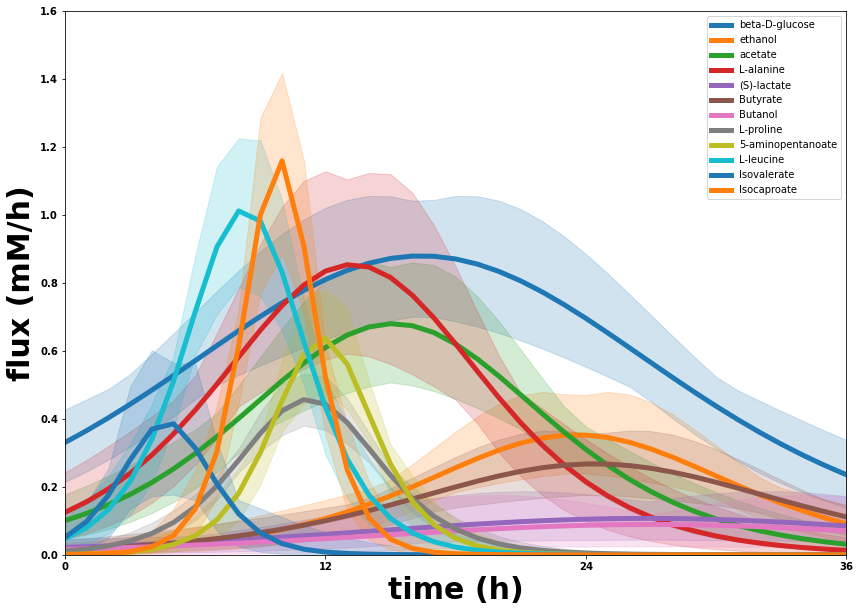

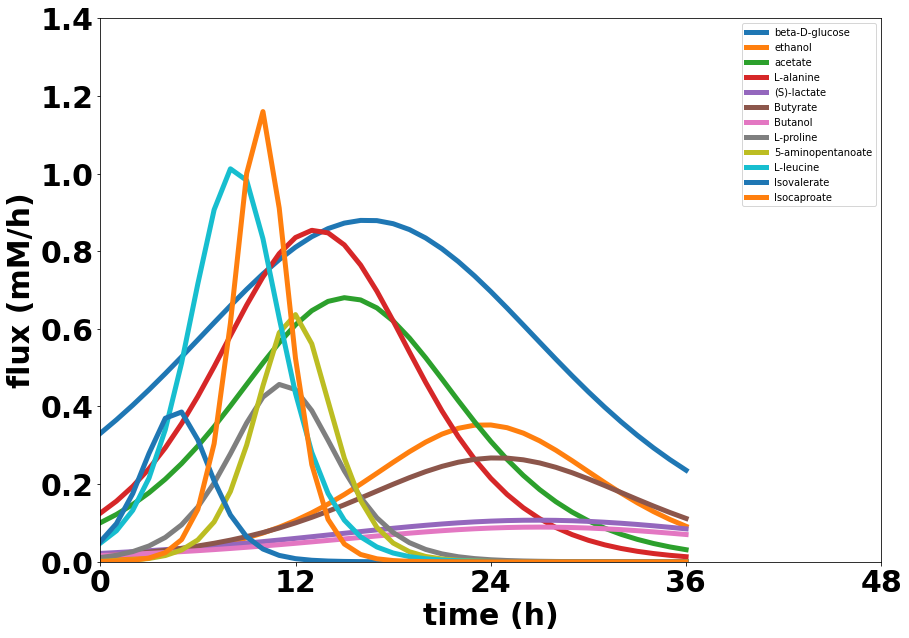

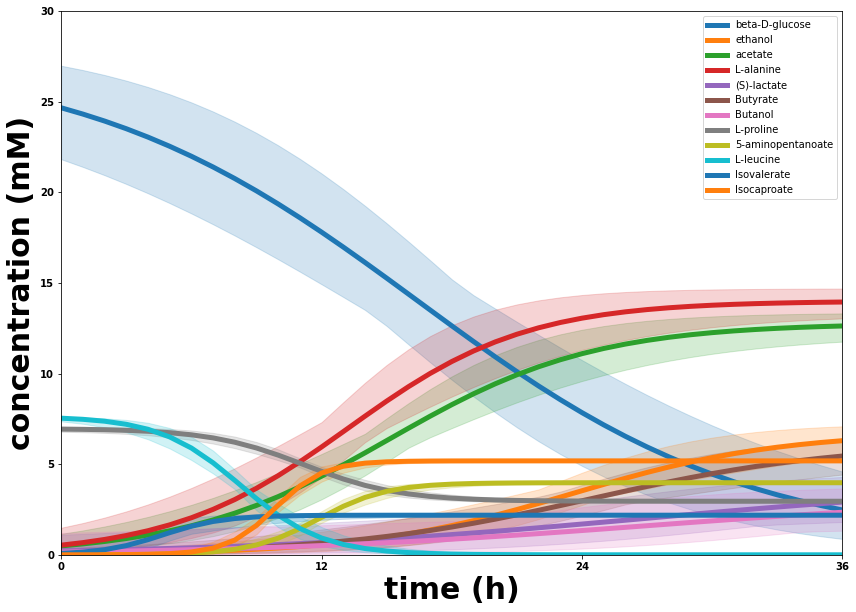

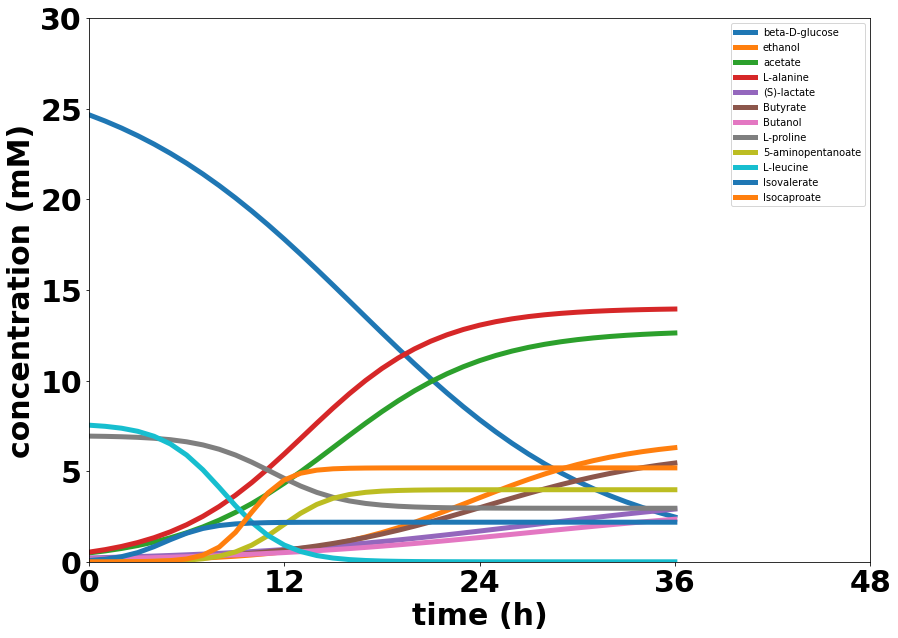

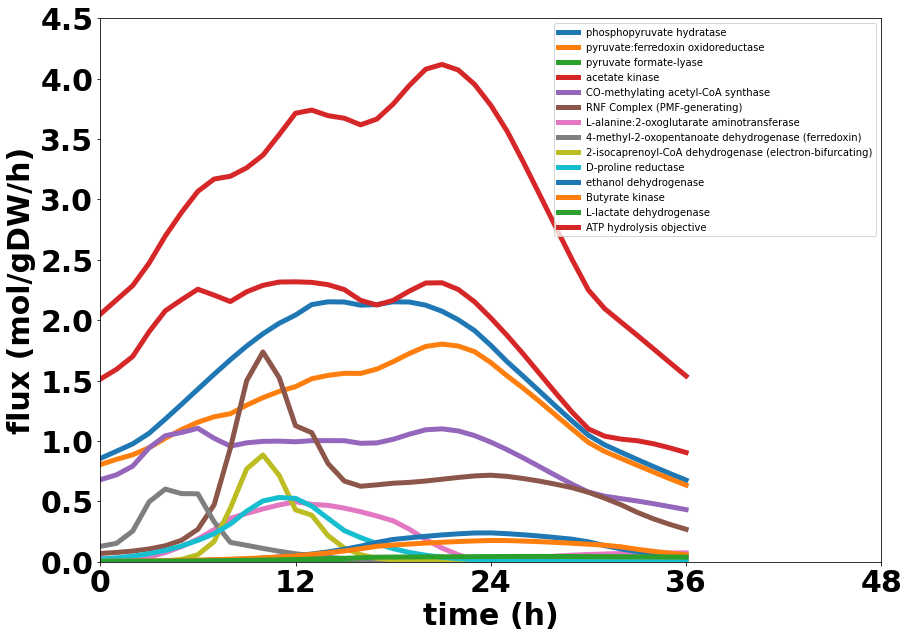

In [80]:
tracked_e = [
    "ID_391",
    "ID_53",
    "ID_36",
    "FHL2",
    "ID_280",
    "RNF-Complex",
    "ID_326",
    "ID_336",
    "ID_369",
    "ID_383",
    "BUK",
    "ID_660",
    "RXN-19534",
    "ICCoA-DHG-EB",
    "ID_314",
    "Ex_biomass",
    "ATP_sink",
]
tracked = [tracked_e[i-1] for i in [1, 2, 3, 5, 7, 6, 8, 13, 14, 15, 10, 11, 12, 17]]
dfba_main("../../data/coeffs.xlsx",
# dfva_main("../../data/coeffs.xlsx", 
          tracked,
          t_max=36,
          resolution=1,
          obj="ATP_sink",
          ko=None
         )

## Compute flux proportions for selected metabolites

In [14]:
def ac_prop(specsheet, met_id='acoa', modelfile="../../data/icdf843.json", t_max=48, resolution=1, dry_run=True, switch=27):
    """Like dfba_main, but writes fluxes for acetate reactions.
    Plot with plotFluxArea.m
    """
    obj = 'ATP_sink'
        
    model = cb.io.load_json_model(modelfile)
    
    init_cnc = dict()
    for rxn in model.reactions:
        if rxn.id.startswith('Ex_') and rxn.id.endswith('L') or rxn.id in ['Ex_gly', 'Ex_his']:
            init_cnc[rxn.id] = rxn.upper_bound
            rxn.upper_bound *= 0.03
    model.reactions.Ex_glc.upper_bound=0
    
    params = pd.read_excel(specsheet, sheet_name='cf', header=0, index_col=0)
    par_lb = pd.read_excel(specsheet, sheet_name='lb', header=0, index_col=0)
    par_ub = pd.read_excel(specsheet, sheet_name='ub', header=0, index_col=0)

    # Initialize results dataframes
    timecourse = list(range(0, t_max + resolution, resolution))
    
    ac_rxns_in = []
    ac_data_in = []
    ac_rxns_ot = []
    ac_data_ot = []
    
    try:
        ac = model.metabolites.get_by_id(met_id + "_c")
    except KeyError:
        print(f"'{met_id}_c' is not a valid metabolite.")
        print('END')
        return
    
    print('dFBA log: simulation output begin.')
    mets = params.index.to_numpy()
    fulldata = [params.to_numpy(), par_lb.to_numpy(), par_ub.to_numpy()]
    # Iterate over time series, metabolites
    for i, t in enumerate(timecourse):
        for j, met in enumerate(mets):
            ## Assemble logistic coefficients ##
            data = [[a[j, b] for a in fulldata] for b in range(4)]
            update_uptake_bounds(model, t, met, *data)
        sol = lsol(model)
        if i % 10 == 0:  
            print(f'dFBA log: Time = {t}  (cycle {i}) \tFBA solution: {sol.fluxes["ATP_sink"]}')
        if sol.fluxes[obj] < 0.0001:
            print(f'dFBA log: infeasible solution on cycle {i}.')
        if i in [0, 12, 20, 24, 36, 48]:
            print("time = " + str(i))
            print(ac.summary(solution=sol))

        localdata_in = {}
        localdata_ot = {}
        for rxn in model.reactions:
            if (ac in rxn.reactants and sol.fluxes[rxn.id] > 1E-5) or (ac in rxn.products and sol.fluxes[rxn.id] < -1E-5):
                localdata_ot[rxn.id] = rxn.metabolites[ac] * sol.fluxes[rxn.id]
            if (ac in rxn.reactants and sol.fluxes[rxn.id] < -1E-5) or (ac in rxn.products and sol.fluxes[rxn.id] > 1E-5):
                localdata_in[rxn.id] = rxn.metabolites[ac] * sol.fluxes[rxn.id]
        ac_data_in.append(localdata_in)
        ac_data_ot.append(localdata_ot)
        for k in localdata_in:
            ac_rxns_in.extend([k for k in localdata_in])
        for k in localdata_ot:
            ac_rxns_ot.extend([k for k in localdata_ot])
            
    if not dry_run:    
        rids_in = list(set(ac_rxns_in))
        rids_ot = list(set(ac_rxns_ot))
        flxs_in = pd.DataFrame(data=np.zeros((len(timecourse), len(rids_in))), index=timecourse, columns=rids_in)
        flxs_ot = pd.DataFrame(data=np.zeros((len(timecourse), len(rids_ot))), index=timecourse, columns=rids_ot)
        rnms_in = [model.reactions.get_by_id(rid).name for rid in rids_in]
        rnms_ot = [model.reactions.get_by_id(rid).name for rid in rids_ot]
        with open(f'../../data/{met_id}flux_in.txt', 'w') as wfi, open(f'../../data/{met_id}flux_ot.txt', 'w') as wfo:
            wfi.write('time\t' + '\t'.join(rids_in) + '\n')
            wfi.write('time\t' + '\t'.join(rnms_in) + '\n')
            wfo.write('time\t' + '\t'.join(rids_ot) + '\n')
            wfo.write('time\t' + '\t'.join(rnms_ot) + '\n')
            for i, t in enumerate(timecourse):
                wfi.write(str(t))
                wfo.write(str(t))
                for rxn in rids_in:
                    val = ac_data_in[i].get(rxn, 0)
                    wfi.write('\t' + str(val))
                    flxs_in.at[t, rxn] = val
                for rxn in rids_ot:
                    val = ac_data_ot[i].get(rxn, 0)
                    wfo.write('\t' + str(val))
                    flxs_ot.at[t, rxn] = val
                wfi.write('\n')
                wfo.write('\n')
        print("Produced flux percentages:")
        totalflux = flxs_in.to_numpy().sum()
        cuts = flxs_in.sum(axis=0)
        for i, rxn in enumerate(rids_in):
            print(rxn, rnms_in[i], f"{cuts.at[rxn]/totalflux*100:.2f}")
        print("Consumed flux percentages:")
        totalflux = flxs_ot.to_numpy().sum()
        cuts = flxs_ot.sum(axis=0)
        for i, rxn in enumerate(rids_ot):
            print(rxn, rnms_ot[i], f"{cuts.at[rxn]/totalflux*100:.2f}")
        print("Absolute influx:")        
        cuts = flxs_in.sum(axis=0)
        for i, rxn in enumerate(rids_in):
            print(rxn, rnms_in[i], f"{cuts.at[rxn]}")
        print("Absolute outflux:")
        cuts = flxs_ot.sum(axis=0)
        for i, rxn in enumerate(rids_ot):
            print(rxn, rnms_ot[i], f"{cuts.at[rxn]}")
        

In [15]:
ac_prop("../../data/coeffs.xlsx", 
          'acoa',
          t_max=36,
          resolution=1,
          dry_run=False,
          switch=0,
         )

dFBA log: simulation output begin.
dFBA log: Time = 0  (cycle 0) 	FBA solution: 2.0487702297428
time = 0
acoa_c
Formula: C23H38N7O17P3S

Producing Reactions
-------------------
Percent   Flux Reaction                                                           Definition
 45.77%  0.679   ID_326                       co_c + coa_c + fesm_c --> acoa_c + fes_c + h_c
 54.23% 0.8045    ID_53 coa_c + feroxoxi_c + pyr_c <=> acoa_c + co2_c + feroxred_c + 2.0 h_c

Consuming Reactions
-------------------
Percent      Flux Reaction                                       Definition
  0.63% -0.009387   ID_481                   aacoa_c + coa_c <=> 2.0 acoa_c
  0.15% -0.002264   ID_492 aald_c + coa_c + nad_c <=> acoa_c + h_c + nadh_c
 99.21%    -1.472   ID_634                   acoa_c + pi_c <=> ap_c + coa_c
dFBA log: Time = 10  (cycle 10) 	FBA solution: 3.3664378892957574
time = 12
acoa_c
Formula: C23H38N7O17P3S

Producing Reactions
-------------------
Percent   Flux Reaction                            